In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
import logging
import json
import re
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
class Args():
    def __init__(self, input_file=None, output_file=None, bert_model=None, do_lower_case=False, layers="-1,-2,-3,-4", max_seq_length=128, batch_size=16, local_rank=-1, no_cuda=False):
        self.input_file = input_file
        self.output_file = output_file
        self.bert_model = bert_model
        self.do_lower_case = do_lower_case
        self.layers = layers
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size
        self.local_rank = local_rank
        self.no_cuda = no_cuda

In [3]:
from data_load import NerDataset, pad, VOCAB, tag2idx, idx2tag

tokenizer = BertTokenizer.from_pretrained("./bert_model/scibert_scivocab_uncased/vocab.txt", do_lower_case=False)
input_file = '/home/cilab/LabMembers/YS/WWW/finetuning/train.txt'
output_file = 'inspect_output.jsonl'
#bert_model = '/home/cilab/LabMembers/YS/bert_ner/bert_model/scibert_scivocab_uncased'
bert_model = "/mnt_data/models/scibert_Inspec_p/2.pt"
layers = '-1,-5'
max_seq_length = 256
batch_size = 1

args = Args(
    input_file=input_file, 
    output_file=output_file,
    bert_model=bert_model, 
    layers=layers, 
    max_seq_length=max_seq_length,
    batch_size=batch_size
)

if args.local_rank == -1 or args.no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    device = torch.device("cuda", args.local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device: {} n_gpu: {} distributed training: {}".format(device, n_gpu, bool(args.local_rank != -1)))

layer_indexes = [int(x) for x in args.layers.split(",")]

01/31/2020 05:35:57 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file ./bert_model/scibert_scivocab_uncased/vocab.txt
01/31/2020 05:35:57 - INFO - __main__ -   device: cuda n_gpu: 4 distributed training: False


In [4]:
from torch.utils import data

eval_dataset = NerDataset(args.input_file, tokenizer)

In [5]:
import torch
import torch.nn as nn
from pytorch_pretrained_bert import BertModel

class Net(nn.Module):
    def __init__(self, top_rnns=False, vocab_size=None, device='cpu', finetuning=False, bert_type='bert-base-cased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_type)

        self.top_rnns=top_rnns
        if top_rnns:
            self.rnn = nn.LSTM(bidirectional=True, num_layers=2, input_size=768, hidden_size=768//2, batch_first=True)
        self.fc = nn.Linear(768, vocab_size)

        self.device = device
        self.finetuning = finetuning

    def forward(self, x, y, ):
        '''
        x: (N, T). int64
        y: (N, T). int64
        Returns
        enc: (N, T, VOCAB)
        '''
        x = x.to(self.device)
        y = y.to(self.device)
        
        if self.training and self.finetuning:
            # print("->bert.train()")
            self.bert.train()
            encoded_layers, _ = self.bert(x)
            enc = encoded_layers[-1]
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers, _ = self.bert(x)
                enc = encoded_layers[-1]

        if self.top_rnns:
            enc, _ = self.rnn(enc)
        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return encoded_layers, logits, y, y_hat

In [13]:
pretrained_bert = Net(True, len(VOCAB), device, False).cuda()
ck = "./finetuned_by_WWW/1.pt"
checkpoint = torch.load(ck)
pretrained_bert.load_state_dict(checkpoint['model_state_dict'],strict=False)

01/31/2020 05:39:29 - INFO - pytorch_pretrained_bert.modeling -   loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/35d8b9d36faaf46728a0192d82bf7d00137490cd6074e8500778afed552a67e5.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
01/31/2020 05:39:29 - INFO - pytorch_pretrained_bert.modeling -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
01/31/2020 05:39:29 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

_IncompatibleKeys(missing_keys=['rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l0_reverse', 'rnn.weight_hh_l0_reverse', 'rnn.bias_ih_l0_reverse', 'rnn.bias_hh_l0_reverse', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'rnn.weight_ih_l1_reverse', 'rnn.weight_hh_l1_reverse', 'rnn.bias_ih_l1_reverse', 'rnn.bias_hh_l1_reverse'], unexpected_keys=[])

In [15]:
scibert = Net(True, len(VOCAB), device, False, bert_type='bert_model/scibert_scivocab_uncased').cuda()
ck = "/mnt_data/models/scibert_WWW/1.pt"
checkpoint = torch.load(ck)
scibert.load_state_dict(checkpoint['model_state_dict'],strict=False)

01/31/2020 07:01:20 - INFO - pytorch_pretrained_bert.modeling -   loading weights file bert_model/scibert_scivocab_uncased/pytorch_model.bin
01/31/2020 07:01:20 - INFO - pytorch_pretrained_bert.modeling -   loading configuration file bert_model/scibert_scivocab_uncased/config.json
01/31/2020 07:01:20 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 31090
}



_IncompatibleKeys(missing_keys=['rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l0_reverse', 'rnn.weight_hh_l0_reverse', 'rnn.bias_ih_l0_reverse', 'rnn.bias_hh_l0_reverse', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'rnn.weight_ih_l1_reverse', 'rnn.weight_hh_l1_reverse', 'rnn.bias_ih_l1_reverse', 'rnn.bias_hh_l1_reverse'], unexpected_keys=[])

In [16]:
def get_embeddings_layer(model):
    embeddings_layer = list(model.modules())[2]
    return embeddings_layer.cuda()

In [18]:
from pytorch_pretrained_bert.modeling import BertEmbeddings

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
eval_dataset = NerDataset(args.input_file, tokenizer)

eval_dataloader = data.DataLoader(dataset=eval_dataset,
                                 batch_size=args.batch_size,
                                 shuffle=False,
                                 num_workers=4,
                                 collate_fn=pad)
tokenizer = BertTokenizer.from_pretrained("./bert_model/scibert_scivocab_uncased/vocab.txt", do_lower_case=False)
seval_dataset = NerDataset(args.input_file, tokenizer)

seval_dataloader = data.DataLoader(dataset=eval_dataset,
                                 batch_size=args.batch_size,
                                 shuffle=False,
                                 num_workers=4,
                                 collate_fn=pad)

01/31/2020 07:27:36 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
01/31/2020 07:27:36 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file ./bert_model/scibert_scivocab_uncased/vocab.txt


In [19]:
from tqdm import tqdm
import pandas as pd
import numpy as np

torch.manual_seed(5)
torch.cuda.manual_seed_all(5)

def get_sample(model, iterater):
    model.eval()
    unique_id = 0

    break_point = False
    
    df_id, df_token, df_feat, df_y, df_pred = [], [], [], [], []
    for i, batch in enumerate(tqdm(eval_dataloader)):
        if i<4:
            continue
        elif i==12:
            break
        #input_ids = input_ids.to(device)
        #input_mask = input_mask.to(device)
        words, x, is_heads, tags, y, seqlens = batch
        print(words)
        #print(words)
        #print(tags)
        #print(y)
        #print(y.numpy()[0])
        #for w, l in zip(tokenizer.tokenize(words[0]), y.numpy()[0]):
        #    print(l, w)
        with torch.no_grad():
            embeddings = model(x.cuda(), token_type_ids=None)
        embeddings = embeddings.squeeze()
        #print(all_encoder_layers)
        for word in words:
            for index, (token, l) in enumerate(zip(tokenizer.tokenize(word), y.numpy()[0])):
                if token in ['[CLS]', '[SEP]']:
                    continue
                df_id.append(unique_id)
                df_token.append(token)
                df_feat.append(embeddings[index].cpu().detach().numpy())
                df_y.append(l)
                unique_id += 1
        #print(tags)
        #print(embeddings.shape)
    df_feat = np.array(df_feat)
    feat_cols = ['feat'+str(i) for i in range(df_feat.shape[1])]
    df = pd.DataFrame(df_feat, columns=feat_cols)
    df['id'] = df_id
    df['token'] = df_token
    df['label'] = df_y
    
    return df, feat_cols

In [20]:
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compose_2d(df, feat_cols):
    tsne = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=300, random_state=1)
    #verbose=1, perplexity=40, 
    tsne_results = tsne.fit_transform(df.loc[:,feat_cols].values)
    return tsne_results

In [23]:
%matplotlib inline
def get_plot(df, tsne_results, title):
    gcm = plt.get_cmap('Greens')
    plt.figure(figsize=(7, 7))
    #plt.tight_layout(-0.3)
    plt.axis('off')
    #plt.margins(x=-0.4,y=-0.4)
    #plt.tight_layout()
    plt.title(title)
    plt.xticks([], [])
    plt.yticks([], [])
    norm = plt.Normalize(tsne_results[:, 2].min(), tsne_results[:, 2].max())
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], marker=None, s=0)
    for i, word in enumerate(df['token']):
        if norm(tsne_results[i, 2]) < 0.5:
            font_size = 13
        elif norm(tsne_results[i, 2]) >= 0.5 and norm(tsne_results[i, 2]) < 0.75:
            font_size = 16
        elif norm(tsne_results[i, 2]) >= 0.75 and norm(tsne_results[i, 2]) < 0.8:
            font_size = 18
        elif norm(tsne_results[i, 2]) >= 0.8 and norm(tsne_results[i, 2]) < 0.85:
            font_size = 21
        elif norm(tsne_results[i, 2]) >= 0.8 and norm(tsne_results[i,
                                                                   2]) < 0.9:
            font_size = 24
        else:
            font_size = 28
        #plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=font_size, color=gcm(norm(tsne_results[i, 2])+0.7))
        plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=15, color=gcm(2.5))
        #plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=round(font_size)%30)
    plt.show()
    plt.savefig('emb_result/'+'gg'+'.png') 


In [28]:
%%sh
pip3 install tk

You are using pip version 8.1.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
%matplotlib tk

ModuleNotFoundError: No module named 'tkinter'

  0%|          | 1/6981 [00:00<58:49,  1.98it/s]


['[CLS] in this paper we propose several link recommendation criteria , based on both user attributes and graph structure . [SEP]']
['[CLS] to discover the candidates that satisfy these criteria , link relevance is estimated using a random walk algorithm on an augmented social graph with both attribute and structure information . [SEP]']
['[CLS] the global and local influence of the attributes is leveraged in the framework as well . [SEP]']
['[CLS] besides link recommendation , our framework can also rank attributes in a social network . [SEP]']
['[CLS] experiments on dblp and imdb data sets demonstrate that our method outperforms state-of-the-art methods based on network structure and node attribute information for link recommendation . [SEP]']
['[CLS] -DOCSTART- [SEP]']
['[CLS] an infrastructure for searching , reusing and evolving distributed ontologies the vision of the semantic web can only be realized through proliferation of well-known ontologies describing different domains . [

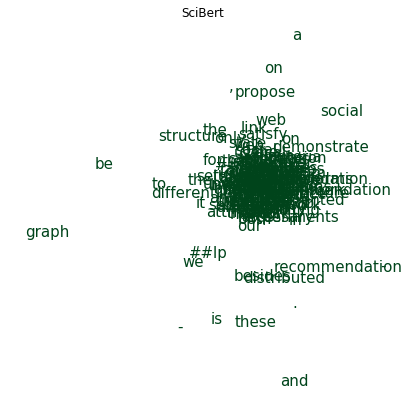

<Figure size 432x288 with 0 Axes>

In [24]:
plot_data = []

for model in [scibert]:
    emb_layer = get_embeddings_layer(model)
    df, cols = get_sample(emb_layer, seval_dataloader)
    feat = compose_2d(df, cols)
    plot_data.append((df, feat))
title = ["SciBert"]
for i, (df, feat) in enumerate(plot_data):
    get_plot(df, feat.copy(), title[i])

  0%|          | 9/6981 [00:00<30:16,  3.84it/s]

['[CLS] in this paper we propose several link recommendation criteria , based on both user attributes and graph structure . [SEP]']
['[CLS] to discover the candidates that satisfy these criteria , link relevance is estimated using a random walk algorithm on an augmented social graph with both attribute and structure information . [SEP]']
['[CLS] the global and local influence of the attributes is leveraged in the framework as well . [SEP]']
['[CLS] besides link recommendation , our framework can also rank attributes in a social network . [SEP]']
['[CLS] experiments on dblp and imdb data sets demonstrate that our method outperforms state-of-the-art methods based on network structure and node attribute information for link recommendation . [SEP]']
['[CLS] -DOCSTART- [SEP]']
['[CLS] an infrastructure for searching , reusing and evolving distributed ontologies the vision of the semantic web can only be realized through proliferation of well-known ontologies describing different domains . [

  0%|          | 9/6981 [00:00<07:41, 15.12it/s]


[t-SNE] Computing 179 nearest neighbors...
[t-SNE] Indexed 180 samples in 0.000s...
[t-SNE] Computed neighbors for 180 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 180 / 180
[t-SNE] Mean sigma: 8.365702
[t-SNE] KL divergence after 250 iterations with early exaggeration: 144.840790
[t-SNE] KL divergence after 300 iterations: 2.853145


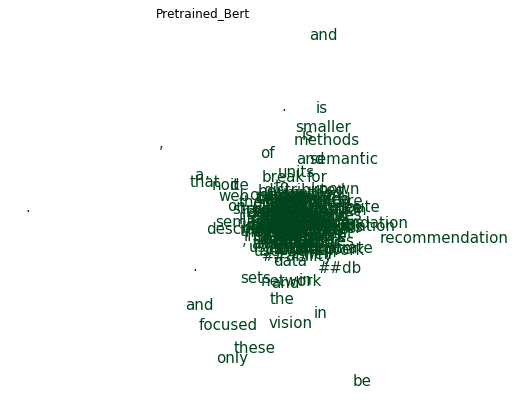

<Figure size 432x288 with 0 Axes>

In [25]:
plot_data = []

for model in [pretrained_bert]:
    emb_layer = get_embeddings_layer(model)
    df, cols = get_sample(emb_layer, seval_dataloader)
    feat = compose_2d(df, cols)
    plot_data.append((df, feat))
title = ["Pretrained_Bert"]
for i, (df, feat) in enumerate(plot_data):
    get_plot(df, feat.copy(), title[i])